## Load packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\Victo\AppData\Local\Temp\ipykernel_25672\3818186681.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
df = pd.read_csv('data_cleaned.csv')

# indicate dummy features
df.iloc[:,19:99] = df.iloc[:,19:99].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 99 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   income_am               4947 non-null   float64 
 1   profit_last_am          4947 non-null   float64 
 2   profit_am               4947 non-null   float64 
 3   damage_am               4947 non-null   float64 
 4   crd_lim_rec             4947 non-null   float64 
 5   cab_requests            4947 non-null   int64   
 6   bar_no                  4947 non-null   int64   
 7   neighbor_income         4947 non-null   float64 
 8   age                     4947 non-null   int64   
 9   tenure_mts              4947 non-null   int64   
 10  tenure_yrs              4947 non-null   int64   
 11  claims_am               4947 non-null   float64 
 12  nights_booked           4947 non-null   int64   
 13  shop_am                 4947 non-null   int64   
 14  outcome_profit          

In [3]:
# Dropping the features that need to be predicted EXCEPT the feature 'outcome_damage_inc'.
df = df.drop(['outcome_profit', 'outcome_damage_amount'], axis=1)

In [4]:
df['outcome_damage_inc'].value_counts()

0    3682
1    1265
Name: outcome_damage_inc, dtype: int64

# Train test split and standardisation

### shuffle

In [5]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### Train/test-split

In [7]:
# Import the function
from sklearn.model_selection import train_test_split

# Split of feaures and outcomes
X = df_shuffle.drop(['outcome_damage_inc'],1)
y = df_shuffle['outcome_damage_inc']


# train/split in training and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# train/split in training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=4321)

C:\Users\Victo\AppData\Local\Temp\ipykernel_25672\2116912031.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_damage_inc'],1)


### standardise

In [8]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_trainval_stand = X_train_val.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()


X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])

X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

# Algorithms

Almost all algorithms from the regression setting can also be used as a classifier in Sklearn

# Logistic regression classifier

In [9]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10000, max_iter=200) 
logreg.fit(X_train_stand, y_train)

c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10000, max_iter=200)

In [10]:
print(logreg.score(X_train_stand, y_train)) # training set
print(logreg.score(X_val_stand, y_val)) # validation set

0.764612954186414
0.7361111111111112


In [11]:
# predict the outcomes for the validation dataset
y_val_pred = logreg.predict(X_val_stand)
y_val_pred_prob = logreg.predict_proba(X_val_stand)

### evaluation

In [12]:
# construct the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, y_val_pred)
print(confusion_matrix)

[[548  29]
 [180  35]]


NIPTest

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       577
           1       0.55      0.16      0.25       215

    accuracy                           0.74       792
   macro avg       0.65      0.56      0.55       792
weighted avg       0.70      0.74      0.68       792



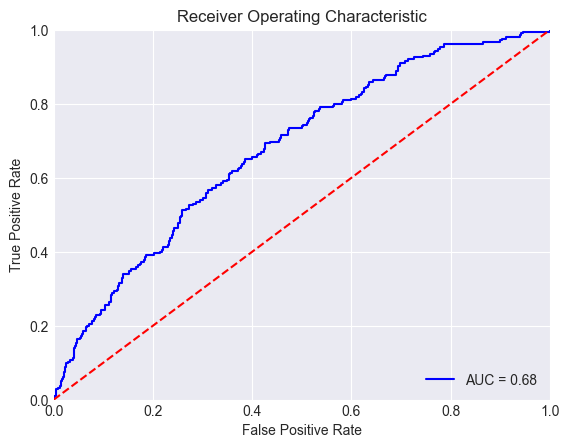

In [14]:
# print the ROC-curve

import sklearn.metrics as metrics
preds = y_val_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Calibration

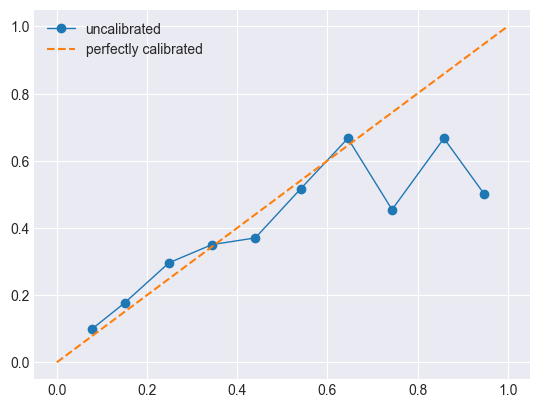

In [15]:
# check if model is well calibrated
from sklearn.calibration import calibration_curve
y_pred_val_prob = logreg.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()

How to correct ?
- Isotonic regression

In [20]:
# fit the model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=10000, max_iter=200) 
logreg.fit(X_train_stand, y_train)

c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10000, max_iter=200)

In [21]:
# calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

isotonic = CalibratedClassifierCV(logreg, cv='prefit', method='isotonic')
isotonic.fit(X_val_stand, y_val)

CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(C=10000, max_iter=200),
                       method='isotonic')

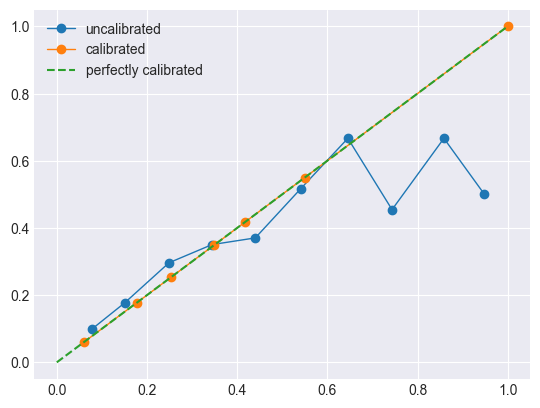

In [22]:
# the calibration plot
y_val_pred_prob_c = isotonic.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

calibrated aligns with the perfect calibrated line

### evaluation

In [23]:
y_pred = logreg.predict(X_val_stand)
y_pred_c = isotonic.predict(X_val_stand)

print(classification_report(y_val, y_pred))
print(classification_report(y_val, y_pred_c))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       577
           1       0.55      0.16      0.25       215

    accuracy                           0.74       792
   macro avg       0.65      0.56      0.55       792
weighted avg       0.70      0.74      0.68       792

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       577
           1       0.56      0.16      0.25       215

    accuracy                           0.74       792
   macro avg       0.66      0.56      0.55       792
weighted avg       0.70      0.74      0.68       792



### option 2

In [24]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

logreg2 = LogisticRegression(C=10000, max_iter=1000) 
isotonic2 = CalibratedClassifierCV(logreg2, cv=3, method='isotonic')  # divide data in 3 folds
isotonic2.fit(X_train_stand, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LogisticRegression(C=10000, max_iter=1000),
                       method='isotonic')

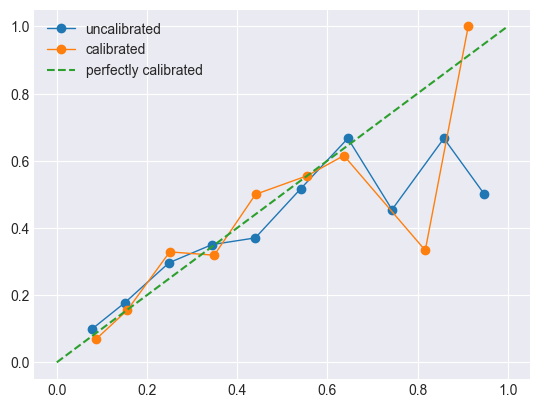

In [27]:
y_val_pred_prob_c2 = isotonic2.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c2[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

### evaluation

In [28]:
y_pred_c2 = isotonic2.predict(X_val_stand)
print(classification_report(y_val, y_pred_c))
print(classification_report(y_val, y_pred_c2))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       577
           1       0.56      0.16      0.25       215

    accuracy                           0.74       792
   macro avg       0.66      0.56      0.55       792
weighted avg       0.70      0.74      0.68       792

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       577
           1       0.55      0.10      0.17       215

    accuracy                           0.73       792
   macro avg       0.65      0.53      0.50       792
weighted avg       0.69      0.73      0.66       792



# Polynomials and penalisation

### random search

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stand)
X_trainval_poly = poly.transform(X_trainval_stand)
X_val_poly = poly.transform(X_val_stand)

In [30]:
from sklearn.model_selection import RandomizedSearchCV

C = [round(x,5) for x in np.linspace(start = 0.0001, stop = 10, num = 1000)]
random_grid = {'C': C}

logreg = LogisticRegression(max_iter=1000) 
log_random = RandomizedSearchCV(estimator=logreg, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1, random_state=1234)
log_random.fit(X_train_poly, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.01011, 0.02012, 0.03013,
                                              0.04014, 0.05015, 0.06016,
                                              0.07017, 0.08018, 0.09019, 0.1002,
                                              0.11021, 0.12022, 0.13023,
                                              0.14024, 0.15025, 0.16026,
                                              0.17027, 0.18028, 0.19029, 0.2003,
                                              0.21031, 0.22032, 0.23033,
                                              0.24034, 0.25035, 0.26036,
                                              0.27037, 0.28038, 0.29039, ...]},
                   random_state=1234, verbose=2)

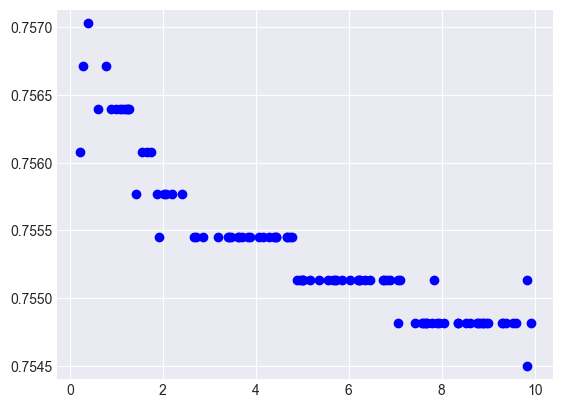

In [32]:
out = pd.DataFrame(log_random.cv_results_)
plt.ylim(out['mean_test_score'].min()-0.0001, out['mean_test_score'].max()+0.0001)
plt.scatter(out['param_C'], out['mean_test_score'], c='blue')

In [33]:
log_random.best_params_

{'C': 0.4005}

### grid search (to focus on small values + include the calibration in the fit)

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)

C = [x for x in np.linspace(start=0.0001, stop=1, num=50)]  #?????????????????????numbers??????????????????????
class_weight = ['balanced']

random_grid = {'C': C, 'class_weight': class_weight}

# the object to fit the model
logreg_balanced = LogisticRegression(max_iter=1000) 

#object for the randomised search
log_grid = GridSearchCV(estimator=logreg_balanced, param_grid=random_grid, scoring=prec_scorer, cv=3, verbose=2,  n_jobs=-1)
isotonic_log = CalibratedClassifierCV(log_grid, cv=3, method='isotonic')

#Fitting model (model+ calibration)
isotonic_log.fit(X_train_poly, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


CalibratedClassifierCV(cv=3,
                       estimator=GridSearchCV(cv=3,
                                              estimator=LogisticRegression(max_iter=1000),
                                              n_jobs=-1,
                                              param_grid={'C': [0.0001,
                                                                0.02050612244897959,
                                                                0.04091224489795919,
                                                                0.06131836734693878,
                                                                0.08172448979591837,
                                                                0.10213061224489796,
                                                                0.12253673469387756,
                                                                0.14294285714285712,
                                                                0.16334897959183672,
                                                                0.18375510204081633,
                                                                0.2041612244897959,
                                                                0.224567346938775...
                                                                0.32659795918367346,
                                                                0.34700408163265306,
                                                                0.36741020408163266,
                                                                0.3878163265306122,
                                                                0.4082224489795918,
                                                                0.4286285714285714,
                                                                0.449034693877551,
                                                                0.4694408163265306,
                                                                0.4898469387755102,
                                                                0.5102530612244898,
                                                                0.5306591836734694,
                                                                0.551065306122449,
                                                                0.5714714285714285,
                                                                0.5918775510204082, ...],
                                                          'class_weight': ['balanced']},
                                              scoring=make_scorer(accuracy_score),
                                              verbose=2),
                       method='isotonic')

### evaluation

In [38]:
isotonic_log.score(X_val_poly, y_val)

0.7323232323232324

In [39]:
y_pred_poly = isotonic_log.predict(X_val_poly)
print(classification_report(y_val, y_pred_poly))

              precision    recall  f1-score   support

           0       0.74      0.96      0.84       577
           1       0.53      0.12      0.19       215

    accuracy                           0.73       792
   macro avg       0.64      0.54      0.52       792
weighted avg       0.69      0.73      0.66       792



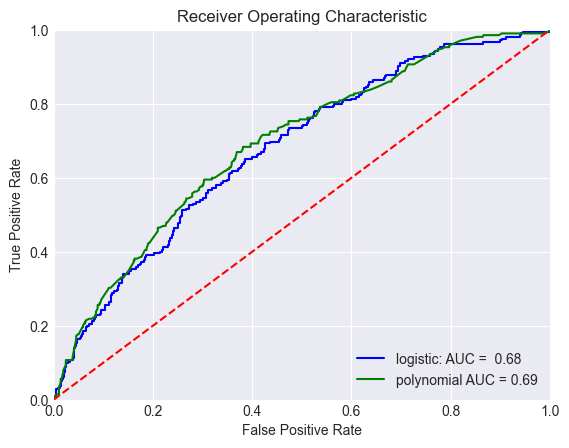

In [41]:
# calculate the fpr and tpr for all thresholds of the classification
preds = y_val_pred_prob[:,1]
preds_poly = isotonic_log.predict_proba(X_val_poly)[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_val, preds_poly)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()